In [112]:
# useful additional packages 
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from random import random,randint
import numpy as np
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm
import cvxopt as cvx
import cvxopt.lapack
import time
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import picos as pic
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer

warnings.filterwarnings('ignore')



# Define C and B

In [135]:
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
def Cjk_generator(n,j,k):
    l = list(range(0,n))
    for i in range(n):
        l[i] = PauliI
    l[j] = PauliZ
    l[k] = PauliZ
    zjzk = l[0]
    for i in range(n-1):
        zjzk = np.kron(zjzk,l[i+1])
    h = list(range(0,n))
    for i in range(n):
        h[i] = PauliI
    h[j]=PauliZ
    zj = h[0]
    for i in range(n-1):
        zj = np.kron(zj,h[i+1])
    for i in range(n):
        h[i] = PauliI
    h[k]=PauliZ
    zk = h[0]
    for i in range(n-1):
        zk = np.kron(zk,h[i+1])
    Cjk = 0.25 * (zjzk + np.eye(pow(2,n)) - zj - zk)
    return Cjk
def Cj_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliZ
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    Cj = 0.5*(n*np.eye(pow(2,n))-sum(b[a] for a in range(n)))
    return Cj
def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = 0.5*(n*np.eye(pow(2,n))-sum(b[a] for a in range(n)))
    return B
#Construct initial state 
def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

# Set up parameters and generate random graph

[[3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3.]]


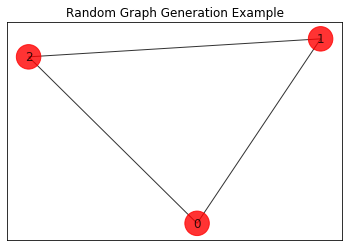

In [144]:
n = 3
p = 0.6

G = ER(n, p)
pos = nx.spring_layout(G)
plot_result(G,[0]*n)
plt.title("Random Graph Generation Example") 
edges = G.edges
E = np.array(list(edges))
print(n*np.eye(pow(2,n)))


# Construct B,C and initial state 

In [154]:
penalty = 50000
Cjk=list(range(0,len(E)))
Cj = Cj_generator(n)
for i in range(len(E)):
    j = E[i][0]
    k = E[i][1]
    Cjk[i]=Cjk_generator(n,j,k)
C = penalty * sum(Cjk[a] for a in range(len(E))) + Cj  
B = B_generator(n)
s = init_s(n)
s_d = (s).T
print(B)
print(C)
print(Cj)

[[ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -3.]]
[[ 1.5 -0.5 -0.5  0.  -0.5  0.   0.   0. ]
 [-0.5  1.5  0.  -0.5  0.  -0.5  0.   0. ]
 [-0.5  0.   1.5 -0.5  0.   0.  -0.5  0. ]
 [ 0.  -0.5 -0.5  1.5  0.   0.   0.  -0.5]
 [-0.5  0.   0.   0.   1.5 -0.5 -0.5  0. ]
 [ 0.  -0.5  0.   0.  -0.5  1.5  0.  -0.5]
 [ 0.   0.  -0.5  0.  -0.5  0.   1.5 -0.5]
 [ 0.   0.   0.  -0.5  0.  -0.5 -0.5  1.5]]
[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 5.00020e+04 0.00000e+00 0.00000e+

# Fine grid for QAOA

Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[46652.36009467]]

 Minimum expectation using QAOA with fine grid :  [[803.76694782]]

 Optimal gamma :  0.9

 Optimal beta :  1.9000000000000001

 Runningtime :  6.425541877746582


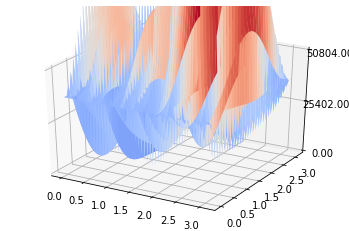

In [156]:
#run the program
start_time = time.time()
step_size   = 0.05
result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
f_p_min = 999
f_p_min_gamma = 0
f_p_min_beta = 0
f_psum = 0

for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
    for j in range(0, int(3.14/step_size)+1):       # j for a_beta
        
        #Construct U_C
        U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
        #Construct U_B
        U_B = expm(-1j*a_beta[j]*B)


        #Construct expection of each subgraph
        state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
        state_d = (state.conjugate()).T # bra
    
        
        f_p = (state_d.dot(C)).dot(state)
        f_psum += f_p
        
            
        if f_p.real < f_p_min:
            f_p_min = f_p.real
            f_p_min_gamma = a_gamma[i]
            f_p_min_beta = a_beta[j]
            
        result_array[i][j] = f_p.real
print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
print("\n Minimum expectation using QAOA with fine grid : ",f_p_min)
print("\n Optimal gamma : ",f_p_min_gamma)
print("\n Optimal beta : ",f_p_min_beta)


end_time = time.time()
print("\n Runningtime : ",end_time - start_time)






# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

gamma = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
beta = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))

for i in range(0, int(3.14/step_size)+1):
    for j in range(0, int(3.14/step_size)+1):
        gamma[i][j] = a_gamma[i]
        beta[i][j] = a_beta[j]



surf = ax.plot_surface(gamma, beta, result_array, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(0, np.ceil(f_p_min)+penalty)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

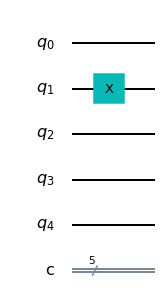

In [7]:
n = 5
qc = QuantumCircuit(n, n)
qc.x(1)
qc.draw(output='mpl')